In [1]:
import numpy as np
import tensorflow as tf
import soundfile as sf
import resampy
import librosa
import spec_augment
import yamnet as yamnet_model
import params as yamnet_params
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import yamnet as yamnet_model
import params as yamnet_params
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from audiomentations import Compose, AddBackgroundNoise, TimeStretch, PitchShift, Shift, AddGaussianNoise
import random

In [2]:
def load_finetunable_yamnet():
    params = yamnet_params.Params()
    model = yamnet_model.yamnet_frames_model(params)
    model.load_weights('yamnet.h5')  # download: https://storage.googleapis.com/audioset/yamnet.h5

    for layer in model.layers[-10:]:
        layer.trainable = True
    return model


In [3]:
# def augment_audio(audio, sr):
#     if np.random.rand() < 0.5:
#         audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=np.random.randint(-2, 3))
#     if np.random.rand() < 0.5:
#         audio = librosa.effects.time_stretch(y=audio, rate=np.random.uniform(0.8, 1.2))
#     if np.random.rand() < 0.5:
#         noise = 0.005 * np.random.randn(len(audio))
#         audio = audio + noise
#     return np.clip(audio, -1.0, 1.0)

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5)
])

# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, ClippingDistortion, PolarityInversion

# augment = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.85, max_rate=1.15, p=0.5),
#     PitchShift(min_semitones=-3, max_semitones=3, p=0.5),
#     Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
#     Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
#     ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=30, p=0.4),  # Random distortion
#     PolarityInversion(p=0.3),  # Flip signal polarity
# ])
# Function to apply SpecAugment
# def apply_specaugment(mel_spec):
#     mel_spec = np.expand_dims(mel_spec, axis=0)  # Add batch dimension
#     mel_spec = tf.convert_to_tensor(mel_spec, dtype=tf.float32)

#     # Apply SpecAugment
#     augmented_mel_spec = spec_augment.augment(mel_spec)

#     return augmented_mel_spec.numpy().squeeze()  # Remove batch dimension

def apply_specaugment(mel_spec, time_mask_param=10, freq_mask_param=8):
    mel = mel_spec.copy()
    num_mel_channels, num_time_steps = mel.shape

    # Time mask
    t = np.random.randint(0, time_mask_param)
    t0 = np.random.randint(0, max(1, num_time_steps - t))
    mel[:, t0:t0 + t] = 0

    # Frequency mask
    f = np.random.randint(0, freq_mask_param)
    f0 = np.random.randint(0, max(1, num_mel_channels - f))
    mel[f0:f0 + f, :] = 0

    return mel


def augment_audio(audio, sr):
    audio = augment(samples=audio, sample_rate=sr)
    return np.clip(audio, -1.0, 1.0)


In [4]:
# def extract_features_finetuned(yamnet, audio_path, sample_rate=16000):
#     # try:
#         y, sr = librosa.load(audio_path, sr=sample_rate)
#         y = augment_audio(y, sr)  # <—— AUGMENTED HERE

#         waveform = tf.convert_to_tensor(y, dtype=tf.float32)
#         waveform = tf.reshape(waveform, [-1])

#         _, embeddings, _ = yamnet(waveform)
#         avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

#         mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
#         mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#         mel_spec_flat = np.mean(mel_spec_db, axis=1)  # (40,)

#         return np.concatenate([avg_embedding, mel_spec_flat])  # (1064,)
def extract_features_finetuned(yamnet, audio_path, sample_rate=16000, use_specaugment=True):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    y = augment_audio(y, sr)  # Apply other augmentations like time stretch, pitch shift

    waveform = tf.convert_to_tensor(y, dtype=tf.float32)
    waveform = tf.reshape(waveform, [-1])

    # Get YAMNet embeddings
    _, embeddings, _ = yamnet(waveform)
    avg_embedding = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

    # Create Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Apply SpecAugment during training (not for validation/test)
    if use_specaugment:
        mel_spec_db = apply_specaugment(mel_spec_db)

    mel_spec_flat = np.mean(mel_spec_db, axis=1)  # (40,)
    
    return np.concatenate([avg_embedding, mel_spec_flat])  # Concatenate YAMNet embeddings with Mel-spectrogram features


In [5]:
def extract_features_from_folder(base_path):
    X, y = [], []
    yamnet = load_finetunable_yamnet()

    label_encoder = LabelEncoder()
    all_labels = sorted(os.listdir(base_path))  # e.g., ['child_danger', 'normal', 'woman_danger']
    label_encoder.fit(all_labels)

    for label in tqdm(all_labels, desc="Processing folders"):
        folder_path = os.path.join(base_path, label)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features_finetuned(yamnet, file_path)
                # features = extract_features_finetuned(yamnet, file_path, augment_audio=True)
                if features is not None:
                    X.append(features)
                    y.append(label)

    X = np.array(X)
    y = label_encoder.transform(y)
    return X, y, label_encoder


In [ ]:
X, y, label_encoder = extract_features_from_folder(r'C:\Users\Vishal Kumar Patel\Desktop\Yamnetmodelproject\data\train')
print("Feature shape:", X.shape)
print("Label shape:", y.shape)
print("Classes:", label_encoder.classes_) 
np.save("X_embeddings_augmented.npy", X)
np.save("y_labels_augmented.npy", y)

Processing folders:   0%|                                                                        | 0/2 [00:00<?, ?it/s]

In [6]:

# Load embeddings and labels from saved files
X = np.load("X_embeddings_augmented.npy")  # shape: (n_samples, 1024)
y = np.load("y_labels_augmented.npy")      # shape: (n_samples,)


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Activation, Multiply, Flatten, Lambda
import tensorflow.keras.backend as K

# ----------------- Data Preprocessing -----------------

# One-hot encode labels
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# Reshape for BiLSTM [samples, time_steps=1, features]
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# ----------------- Attention Block -----------------
def attention_block(inputs):
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Activation('softmax')(attention_weights)
    weighted_input = Multiply()([inputs, attention_weights])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(weighted_input)
    # context_vector = Lambda(lambda x: K.sum(x, axis=1), output_shape=(inputs.shape[1],))(weighted_input)  
    return context_vector

# ----------------- Model Definition -----------------
input_layer = Input(shape=(1, X.shape[1]))  # Define input shape
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_block(x)
x = Flatten()(x) 
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------- Summary -----------------
model.summary()



# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer, Flatten, Multiply, Permute
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



# # One-hot encode labels
# num_classes = len(np.unique(y))
# y_cat = to_categorical(y, num_classes)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# # Reshape for BiLSTM [samples, time_steps=1, features]
# X_train = np.expand_dims(X_train, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=np.argmax(y_cat, axis=1))
# class_weights_dict = dict(enumerate(class_weights))

# # ----------------- Attention Layer -----------------
# class Attention(Layer):
#     def __init__(self, **kwargs):
#         super(Attention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
#                                  initializer='normal', trainable=True)
#         self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
#                                  initializer='zeros', trainable=True)
#         super(Attention, self).build(input_shape)

#     def call(self, x):
#         e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
#         a = tf.keras.backend.softmax(e, axis=1)
#         output = x * a
#         return tf.keras.backend.sum(output, axis=1)

# # ----------------- Model Architecture -----------------
# input_layer = Input(shape=(1, 1064))  # Input shape
# x = tf.keras.layers.Reshape((1064, 1))(input_layer)  # Reshape for LSTM

# x = Bidirectional(LSTM(128, return_sequences=True))(x)
# x = Dropout(0.5)(x)
# x = Attention()(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# output_layer = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 1, 1064)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_3               │ (None, 1, 256)            │       1,221,632 │ input_layer_3[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 1, 256)            │           1,024 │ bidirectional_3[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 1, 256)            │               0 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1, 1)              │             257 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 1, 1)              │               0 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_3 (Multiply)         │ (None, 1, 256)            │               0 │ dropout_6[0][0],           │
│                               │                           │                 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_3 (Lambda)             │ (None, 256)               │               0 │ multiply_3[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 256)               │               0 │ lambda_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 128)               │          32,896 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 128)               │             512 │ dense_10[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_7[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 2)                 │             258 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,256,579 (4.79 MB)

 Trainable params: 1,255,811 (4.79 MB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=64,
#     class_weight=class_weights_dict,
#     callbacks=[early_stop],
#     verbose=1
# )


# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=64,
#     class_weight=class_weights_dict,
#     callbacks=[reduce_lr, early_stop],
#     verbose=1
# )

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# from tensorflow.keras.utils import to_categorical

# ----------------- Callbacks -----------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# ----------------- Train Model -----------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint]
)







Epoch 1/50


C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8210 - loss: 0.4785
Epoch 1: val_loss improved from inf to 0.33801, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8213 - loss: 0.4777 - val_accuracy: 0.8659 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 2/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8999 - loss: 0.2683
Epoch 2: val_loss improved from 0.33801 to 0.30008, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8999 - loss: 0.2684 - val_accuracy: 0.8841 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 3/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9026 - loss: 0.2486
Epoch 3: val_loss improved from 0.30008 to 0.22833, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9027 - loss: 0.2485 - val_accuracy: 0.9124 - val_loss: 0.2283 - learning_rate: 0.0010
Epoch 4/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9028 - loss: 0.2395
Epoch 4: val_loss did not improve from 0.22833
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9028 - loss: 0.2394 - val_accuracy: 0.9035 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 5/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9150 - loss: 0.2201
Epoch 5: val_loss did not improve from 0.22833
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9150 - loss: 0.2202 - val_accuracy: 0.9024 - val_loss: 0.2365 - learning_rate: 0.0010
Epoch 6/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9155 - loss: 0.2156
Epoch 6: val_loss did not improve from 0.22833
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9155 - loss: 0.2156 - val_accuracy: 0.8875 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 7/50
224/226 ━━━━━━━━━━━

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9219 - loss: 0.2008 - val_accuracy: 0.9174 - val_loss: 0.2213 - learning_rate: 5.0000e-04
Epoch 8/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9297 - loss: 0.1876
Epoch 8: val_loss improved from 0.22126 to 0.19626, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9297 - loss: 0.1876 - val_accuracy: 0.9224 - val_loss: 0.1963 - learning_rate: 5.0000e-04
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9341 - loss: 0.1778
Epoch 9: val_loss did not improve from 0.19626
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9341 - loss: 0.1778 - val_accuracy: 0.9163 - val_loss: 0.2122 - learning_rate: 5.0000e-04
Epoch 10/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9258 - loss: 0.1907
Epoch 10: val_loss improved from 0.19626 to 0.19007, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9258 - loss: 0.1906 - val_accuracy: 0.9257 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 11/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9277 - loss: 0.1830
Epoch 11: val_loss did not improve from 0.19007
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9277 - loss: 0.1829 - val_accuracy: 0.8503 - val_loss: 0.3161 - learning_rate: 5.0000e-04
Epoch 12/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9304 - loss: 0.1772
Epoch 12: val_loss did not improve from 0.19007
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9304 - loss: 0.1772 - val_accuracy: 0.9174 - val_loss: 0.2195 - learning_rate: 5.0000e-04
Epoch 13/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9336 - loss: 0.1628
Epoch 13: val_loss improved from 0.19007 to 0.18641, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9336 - loss: 0.1629 - val_accuracy: 0.9224 - val_loss: 0.1864 - learning_rate: 5.0000e-04
Epoch 14/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9433 - loss: 0.1506
Epoch 14: val_loss did not improve from 0.18641
226/226 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9432 - loss: 0.1507 - val_accuracy: 0.9180 - val_loss: 0.1958 - learning_rate: 5.0000e-04
Epoch 15/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9376 - loss: 0.1554
Epoch 15: val_loss did not improve from 0.18641
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9376 - loss: 0.1555 - val_accuracy: 0.9180 - val_loss: 0.2006 - learning_rate: 5.0000e-04
Epoch 16/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9369 - loss: 0.1658
Epoch 16: val_loss improved from 0.18641 to 0.18535, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9368 - loss: 0.1658 - val_accuracy: 0.9241 - val_loss: 0.1854 - learning_rate: 5.0000e-04
Epoch 17/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9324 - loss: 0.1676
Epoch 17: val_loss did not improve from 0.18535
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9324 - loss: 0.1676 - val_accuracy: 0.9174 - val_loss: 0.2187 - learning_rate: 5.0000e-04
Epoch 18/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9341 - loss: 0.1641
Epoch 18: val_loss did not improve from 0.18535
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9341 - loss: 0.1641 - val_accuracy: 0.9180 - val_loss: 0.1984 - learning_rate: 5.0000e-04
Epoch 19/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9354 - loss: 0.1652
Epoch 19: val_loss did not improve from 0.18535
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9355 - loss: 0.1651 - val_accuracy: 0.9191 - val_loss: 0.1956 - learning_rate: 5.0000e-04
Epoch 20

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9353 - loss: 0.1523 - val_accuracy: 0.9290 - val_loss: 0.1717 - learning_rate: 2.5000e-04
Epoch 21/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9497 - loss: 0.1293
Epoch 21: val_loss did not improve from 0.17175
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9496 - loss: 0.1294 - val_accuracy: 0.9235 - val_loss: 0.1930 - learning_rate: 2.5000e-04
Epoch 22/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9443 - loss: 0.1374
Epoch 22: val_loss did not improve from 0.17175
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9443 - loss: 0.1374 - val_accuracy: 0.9346 - val_loss: 0.1819 - learning_rate: 2.5000e-04
Epoch 23/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9437 - loss: 0.1522
Epoch 23: val_loss did not improve from 0.17175
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9436 - loss: 0.1521 - val_accuracy: 0.9279 - val_loss: 0.1797 - learning_rate: 2.5000e-04
Epoch 24

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9560 - loss: 0.1203 - val_accuracy: 0.9340 - val_loss: 0.1716 - learning_rate: 1.2500e-04
Epoch 27/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9425 - loss: 0.1317
Epoch 27: val_loss improved from 0.17160 to 0.16883, saving model to best_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9426 - loss: 0.1317 - val_accuracy: 0.9285 - val_loss: 0.1688 - learning_rate: 1.2500e-04
Epoch 28/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9418 - loss: 0.1423
Epoch 28: val_loss did not improve from 0.16883
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9418 - loss: 0.1422 - val_accuracy: 0.9257 - val_loss: 0.1882 - learning_rate: 1.2500e-04
Epoch 29/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9485 - loss: 0.1284
Epoch 29: val_loss did not improve from 0.16883
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9485 - loss: 0.1284 - val_accuracy: 0.9224 - val_loss: 0.1930 - learning_rate: 1.2500e-04
Epoch 30/50
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9558 - loss: 0.1161
Epoch 30: val_loss did not improve from 0.16883
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9557 - loss: 0.1161 - val_accuracy: 0.9290 - val_loss: 0.1823 - learning_rate: 1.2500e-04
Epoch 31

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9618 - loss: 0.1068 - val_accuracy: 0.9307 - val_loss: 0.1686 - learning_rate: 3.1250e-05
Epoch 35/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9557 - loss: 0.1145
Epoch 35: val_loss did not improve from 0.16864
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9557 - loss: 0.1145 - val_accuracy: 0.9302 - val_loss: 0.1712 - learning_rate: 3.1250e-05
Epoch 36/50
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9567 - loss: 0.1132
Epoch 36: val_loss did not improve from 0.16864
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9567 - loss: 0.1131 - val_accuracy: 0.9296 - val_loss: 0.1714 - learning_rate: 3.1250e-05
Epoch 37/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9578 - loss: 0.1084
Epoch 37: val_loss did not improve from 0.16864
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9578 - loss: 0.1084 - val_accuracy: 0.9318 - val_loss: 0.1724 - learning_rate: 3.1250e-05
Epoch 38

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9337 - loss: 0.1638
✅ Test Accuracy: 93.07%


 1/57 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step

C:\Users\Vishal Kumar Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


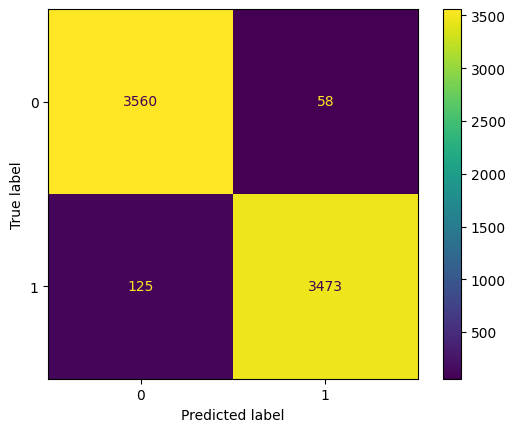

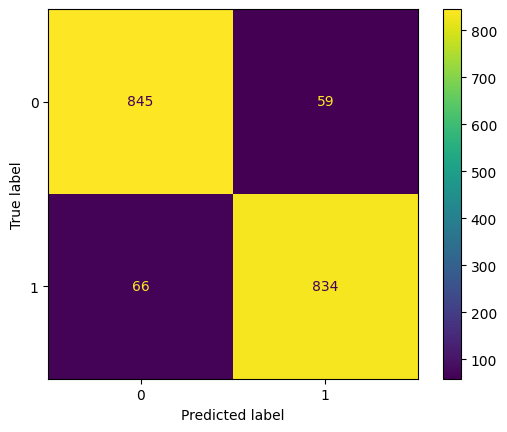

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       904
           1       0.93      0.93      0.93       900

    accuracy                           0.93      1804
   macro avg       0.93      0.93      0.93      1804
weighted avg       0.93      0.93      0.93      1804



In [21]:
predicted_test = model.predict(X_test)
predicted_train = model.predict(X_train)
predicted_class = []
for i in range(len(predicted_train)):
  predicted_class.append(np.argmax(predicted_train[i]))
predicted_class_index = []
for i in range(len(predicted_test)):
  predicted_class_index.append(np.argmax(predicted_test[i]))
rounded_test = np.argmax(y_test,axis=1)
rounded_train = np.argmax(y_train,axis=1)


confusion_matrix = metrics.confusion_matrix(rounded_train, predicted_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()


confusion_matrix = metrics.confusion_matrix(rounded_test, predicted_class_index)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()


print(classification_report(rounded_test, predicted_class_index))



In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=['woman_danger', 'normal']))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

woman_danger       0.93      0.93      0.93       904
      normal       0.93      0.93      0.93       900

    accuracy                           0.93      1804
   macro avg       0.93      0.93      0.93      1804
weighted avg       0.93      0.93      0.93      1804



In [23]:
model.save('final.h5')